In [ ]:
!pip install -U albumentations
!pip install livelossplot

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.5)


In [ ]:
import pandas as pd
import numpy as np
import copy
import cv2
import re
import os

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from livelossplot import PlotLosses
from matplotlib import pyplot as plt

from PIL import Image
from IPython import display

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive')

DIR_INPUT = './'
DIR_TRAIN = './train/'
DIR_TEST = './test/'

OUTPUT_PATH = './drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not os.path.exists('./test/2fd875eaa.jpg'):
  os.system("wget 'https://www.dropbox.com/s/4xxbdnomz9gy9f7/global-wheat-detection.zip?dl=0' -O data.zip")
  os.system("unzip -q data.zip")

# Train data preparation

In [ ]:
train_df = pd.read_csv(DIR_INPUT + 'train.csv')
print(train_df.shape)
print(train_df['width'].unique(), train_df['height'].unique())
train_df.head(2)

(147793, 5)
[1024] [1024]


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1


In [ ]:
train_df['x'], train_df['y'] = -1, -1
train_df['w'], train_df['h'] = -1, -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df.head(2)

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0


We will resize data in **RESIZE_COEF** times  
NOTE! Higher than 4 will break box detection

In [ ]:
RESIZE_COEF = 1  # modulo of 1024 should be zero

for column in ['width', 'height', 'x', 'y', 'w', 'h']:
  train_df[column] = train_df[column] / RESIZE_COEF

train_df.head(2)

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024.0,1024.0,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024.0,1024.0,usask_1,226.0,548.0,130.0,58.0


In [ ]:
image_ids = train_df['image_id'].unique()
len(image_ids)

3373

In [ ]:
COEF_VAL_SIZE = 0.2

train_ids = image_ids[:int(len(image_ids) * (1 - 0.2))] #image_ids[:3323]
valid_ids = image_ids[int(len(image_ids) * (1 - 0.2)):] #image_ids[-3323:]

In [ ]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
train_df.shape, valid_df.shape

((122577, 8), (25216, 8))

In [ ]:
class Averager:

    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # Resize image
        image = cv2.resize(image,(int(1024/RESIZE_COEF), int(1024/RESIZE_COEF)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values

        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] #x2
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] #y2

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}

        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)

            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


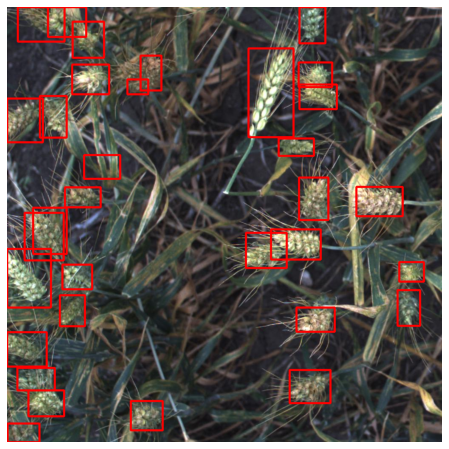

In [ ]:
boxes = targets[3]['boxes'].cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]), #x1,y1
                  (box[2], box[3]), #x2,y2
                  (220, 0, 0),
                  3)

ax.set_axis_off()
ax.imshow(sample)

In [ ]:
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

## Train function

In [ ]:
def train_model(model, optimizer, n_epochs, pth_name):

  liveloss = PlotLosses()
  min_val_loss = np.inf

  model = model.to(device)
  best_model = copy.deepcopy(model.state_dict())
  for epoch in range(n_epochs):
      logs = {}

      loss_train, loss_val = list(), list()

      for images, targets, _ in train_data_loader:

          images = list(image.to(device) for image in images)

          targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)

          losses = sum(loss for loss in loss_dict.values())

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          loss_train.append(losses.item())

      for images, targets, _ in valid_data_loader:

          images = list(image.to(device) for image in images)

          targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)

          losses = sum(loss for loss in loss_dict.values())

          loss_val.append(losses.item())

      if np.nanmean(loss_val) <= min_val_loss:
          min_val_loss = loss_val[-1]
          best_model = copy.deepcopy(model.state_dict())
          torch.save(model.state_dict(), OUTPUT_PATH  + pth_name)

      prefix = ''
      logs[prefix + 'loss'] = np.nanmean(loss_train)
      prefix = 'val_'
      logs[prefix + 'loss'] = np.nanmean(loss_val)
      liveloss.update(logs)
      liveloss.send()

  return best_model

# Train model (first trial)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9,)# weight_decay=5e-4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


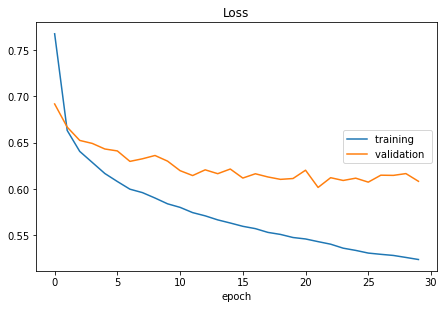

Loss
	training         	 (min:    0.524, max:    0.768, cur:    0.524)
	validation       	 (min:    0.602, max:    0.692, cur:    0.608)


In [ ]:
model = train_model(model, optimizer, 30, 'agro_best_model.pth')

# Test

In [ ]:
test_df = pd.read_csv(DIR_INPUT + 'sample_submission.csv')
print(test_df.shape)
test_df.head(2)

(10, 2)


,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

In [ ]:
WEIGHTS_FILE = OUTPUT_PATH  + 'agro_best_model.pth'
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # Resize image
        image = cv2.resize(image,(int(1024/RESIZE_COEF), int(1024/RESIZE_COEF)))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [ ]:
test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

In [ ]:
test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0]*RESIZE_COEF, j[1][1]*RESIZE_COEF, j[1][2]*RESIZE_COEF, j[1][3]*RESIZE_COEF))
    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }


        results.append(result)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head(2)

,image_id,PredictionString
0,aac893a91,0.9972 553 532 129 191 0.9962 28 457 101 156 0...
1,51f1be19e,0.9980 610 90 158 176 0.9961 501 471 201 108 0...


In [ ]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


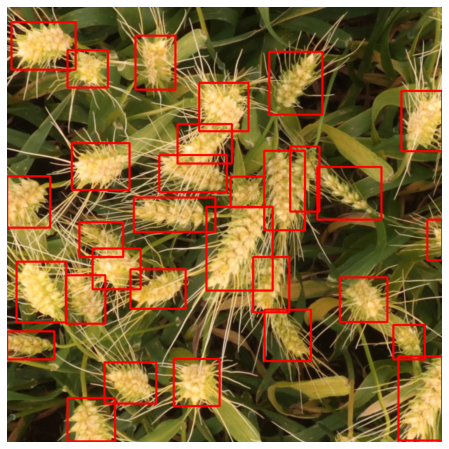

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0),
                  3)

ax.set_axis_off()
ax.imshow(sample)

0.6882 public (315)

# Train model (second trial)

In [ ]:
def get_train_transform():
    return A.Compose([
        #A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=0.15),
        A.ToSepia(p=0.5),
        #A.JpegCompression(quality_lower=0, quality_upper=1, p=0.15),
        A.Blur(blur_limit=(15, 15), p=0.5),
        #A.InvertImg(p=0.5),
        A.Cutout(num_holes=30, max_h_size=30, max_w_size=30, fill_value=64, p=0.5),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

WEIGHTS_FILE = OUTPUT_PATH  + 'agro_best_model.pth'
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, )#weight_decay=5e-4)

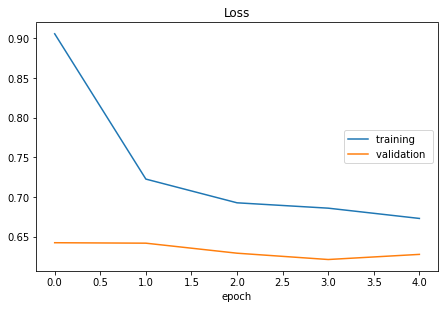

Loss
	training         	 (min:    0.673, max:    0.905, cur:    0.673)
	validation       	 (min:    0.621, max:    0.642, cur:    0.628)


In [ ]:
model = train_model(model, optimizer, 30, 'agro_best_model_v4.pth')

In [ ]:
#         A.Cutout(num_holes=30, max_h_size=30, max_w_size=30, fill_value=64, p=0.5),
#        A.Flip(0.5),
#       A.Blur(blur_limit=(15, 15), p=0.2),

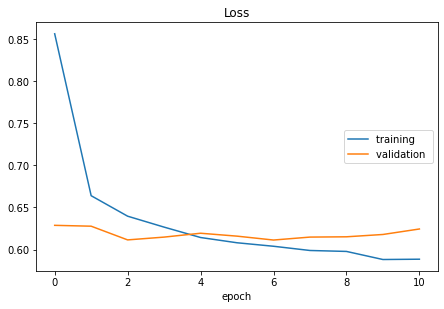

Loss
	training         	 (min:    0.588, max:    0.856, cur:    0.589)
	validation       	 (min:    0.611, max:    0.629, cur:    0.624)


KeyboardInterrupt: ignored

In [ ]:
model = train_model(model, optimizer, 30, 'agro_best_model_v3.pth')

In [ ]:
#        A.Cutout(num_holes=30, max_h_size=30, max_w_size=30, fill_value=64, p=0.5),
#        A.Flip(0.5),

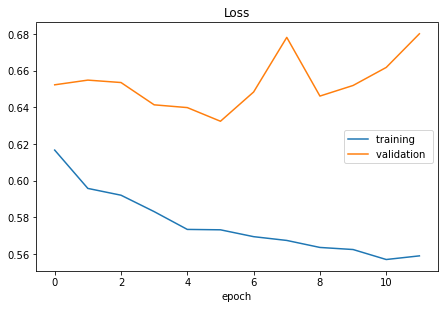

Loss
	training         	 (min:    0.557, max:    0.617, cur:    0.559)
	validation       	 (min:    0.632, max:    0.680, cur:    0.680)


KeyboardInterrupt: ignored

In [ ]:
model = train_model(model, optimizer, 30, 'agro_best_model_v2.pth')